___

<a href='http://www.pieriandata.com'><img src='../Pierian_Data_Logo.png'/></a>
___
<center><em>Copyright Pierian Data</em></center>
<center><em>For more information, visit us at <a href='http://www.pieriandata.com'>www.pieriandata.com</a></em></center>

# BONUS - Multivariate Time Series with RNN
---
----
# PLEASE READ THE FOLLOWING BEFORE GOING THROUGH THIS NOTEBOOK!

## NOTE: In general, it is very difficult to get good performance from an LSTM based RNN model for multivariate series. We highly recommend using SARIMAX based methods if you have a real-world situation requiring multi-variate time series data. You can learn more about this in my [time series course](https://www.udemy.com/python-for-time-series-data-analysis/?couponCode=TIME_SERIES_PYTHON).

## Please do not post questions to the QA forums about your own time series data sets, the QA forums are for course related notebooks and datasets only. Post to discord for your own datasets.
---
---
Appliance Energy Usage: A Multivariate Time Series Forecasting Example

Experimental data used to create regression models of appliances energy use in a low energy building.
Data Set Information:

The data set is at 10 min for about 4.5 months. The house temperature and humidity conditions were monitored with a ZigBee wireless sensor network. Each wireless node transmitted the temperature and humidity conditions around 3.3 min. Then, the wireless data was averaged for 10 minutes periods. The energy data was logged every 10 minutes with m-bus energy meters. Weather from the nearest airport weather station (Chievres Airport, Belgium) was downloaded from a public data set from Reliable Prognosis (rp5.ru), and merged together with the experimental data sets using the date and time column. Two random variables have been included in the data set for testing the regression models and to filter out non predictive attributes (parameters).
Original source of the dataset:

http://archive.ics.uci.edu/ml/datasets/Appliances+energy+prediction
___
___

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# IGNORE THE CONTENT OF THIS CELL
# import tensorflow as tf
# tf.compat.v1.disable_eager_execution()

## Data

Let's read in the data set:

In [3]:
df = pd.read_csv('../DATA/energydata_complete.csv',index_col='date',
                infer_datetime_format=True)

In [4]:
df.head()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
date,,,,,,,,,,,,,,,,,,,,,
2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,...,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,...,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,...,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,...,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389
2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,...,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19735 entries, 2016-01-11 17:00:00 to 2016-05-27 18:00:00
Data columns (total 28 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Appliances   19735 non-null  int64  
 1   lights       19735 non-null  int64  
 2   T1           19735 non-null  float64
 3   RH_1         19735 non-null  float64
 4   T2           19735 non-null  float64
 5   RH_2         19735 non-null  float64
 6   T3           19735 non-null  float64
 7   RH_3         19735 non-null  float64
 8   T4           19735 non-null  float64
 9   RH_4         19735 non-null  float64
 10  T5           19735 non-null  float64
 11  RH_5         19735 non-null  float64
 12  T6           19735 non-null  float64
 13  RH_6         19735 non-null  float64
 14  T7           19735 non-null  float64
 15  RH_7         19735 non-null  float64
 16  T8           19735 non-null  float64
 17  RH_8         19735 non-null  float64
 18  T9           19735 

<AxesSubplot:xlabel='date'>

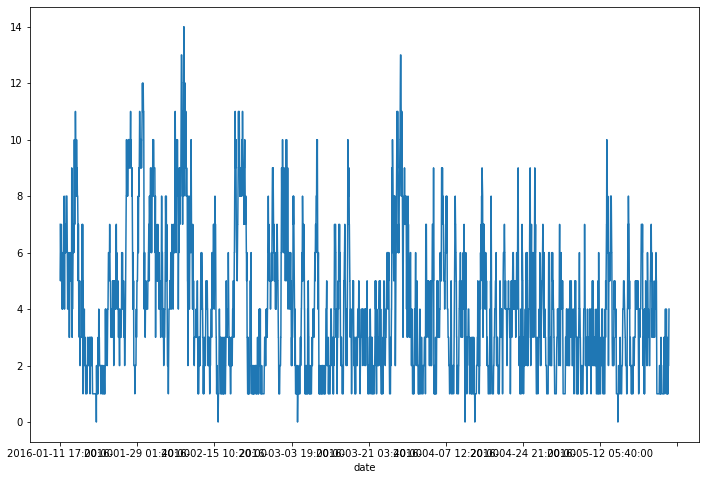

In [6]:
df['Windspeed'].plot(figsize=(12,8))

<AxesSubplot:xlabel='date'>

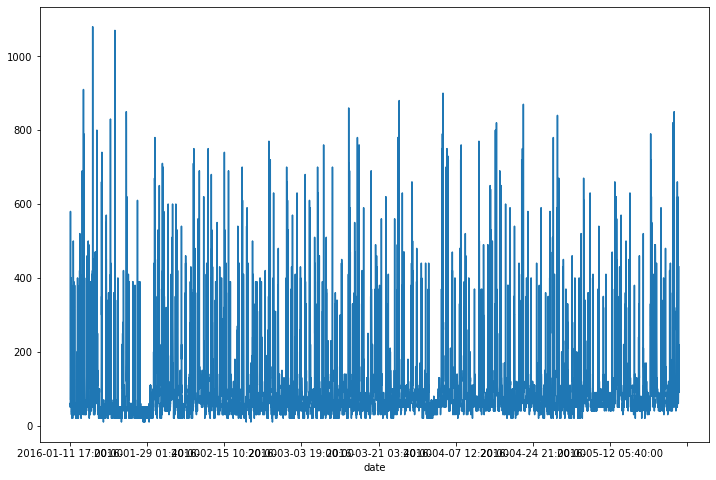

In [7]:
df['Appliances'].plot(figsize=(12,8))

## Train Test Split

In [8]:
len(df)

19735

In [9]:
df.head(3)

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
date,,,,,,,,,,,,,,,,,,,,,
2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,...,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,...,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,...,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668


In [10]:
df.tail(5)

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
date,,,,,,,,,,,,,,,,,,,,,
2016-05-27 17:20:00,100,0,25.566667,46.560000,25.890000,42.025714,27.200000,41.163333,24.7,45.590000,...,23.2,46.7900,22.733333,755.2,55.666667,3.333333,23.666667,13.333333,43.096812,43.096812
2016-05-27 17:30:00,90,0,25.500000,46.500000,25.754000,42.080000,27.133333,41.223333,24.7,45.590000,...,23.2,46.7900,22.600000,755.2,56.000000,3.500000,24.500000,13.300000,49.282940,49.282940
2016-05-27 17:40:00,270,10,25.500000,46.596667,25.628571,42.768571,27.050000,41.690000,24.7,45.730000,...,23.2,46.7900,22.466667,755.2,56.333333,3.666667,25.333333,13.266667,29.199117,29.199117
2016-05-27 17:50:00,420,10,25.500000,46.990000,25.414000,43.036000,26.890000,41.290000,24.7,45.790000,...,23.2,46.8175,22.333333,755.2,56.666667,3.833333,26.166667,13.233333,6.322784,6.322784
2016-05-27 18:00:00,430,10,25.500000,46.600000,25.264286,42.971429,26.823333,41.156667,24.7,45.963333,...,23.2,46.8450,22.200000,755.2,57.000000,4.000000,27.000000,13.200000,34.118851,34.118851


Let's imagine we want to predict just 24 hours into the future, we don't need 3 months of data for that, so let's save some training time and only select the last months data.

In [11]:
df.loc['2016-05-01':]

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
date,,,,,,,,,,,,,,,,,,,,,
2016-05-01 00:00:00,50,0,21.200000,38.200000,18.390000,41.400000,23.200000,36.400000,19.73,37.730000,...,19.166667,38.200000,4.300000,763.700000,86.000000,2.000000,40.000000,2.200000,15.310003,15.310003
2016-05-01 00:10:00,60,0,21.150000,38.172500,18.390000,41.500000,23.133333,36.466667,19.70,37.663333,...,19.133333,38.290000,4.283333,763.716667,86.333333,2.166667,38.166667,2.216667,11.240067,11.240067
2016-05-01 00:20:00,50,0,21.133333,38.090000,18.323333,41.500000,23.200000,36.500000,19.70,37.590000,...,19.133333,38.363333,4.266667,763.733333,86.666667,2.333333,36.333333,2.233333,21.808814,21.808814
2016-05-01 00:30:00,50,0,21.100000,38.090000,18.290000,41.500000,23.200000,36.500000,19.70,37.500000,...,19.166667,38.500000,4.250000,763.750000,87.000000,2.500000,34.500000,2.250000,47.000534,47.000534
2016-05-01 00:40:00,60,0,21.100000,38.030000,18.290000,41.560000,23.200000,36.500000,19.70,37.500000,...,19.166667,38.633333,4.233333,763.766667,87.333333,2.666667,32.666667,2.266667,8.059441,8.059441
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-05-27 17:20:00,100,0,25.566667,46.560000,25.890000,42.025714,27.200000,41.163333,24.70,45.590000,...,23.200000,46.790000,22.733333,755.200000,55.666667,3.333333,23.666667,13.333333,43.096812,43.096812
2016-05-27 17:30:00,90,0,25.500000,46.500000,25.754000,42.080000,27.133333,41.223333,24.70,45.590000,...,23.200000,46.790000,22.600000,755.200000,56.000000,3.500000,24.500000,13.300000,49.282940,49.282940
2016-05-27 17:40:00,270,10,25.500000,46.596667,25.628571,42.768571,27.050000,41.690000,24.70,45.730000,...,23.200000,46.790000,22.466667,755.200000,56.333333,3.666667,25.333333,13.266667,29.199117,29.199117


In [12]:
df = df.loc['2016-05-01':]

Let's also round off the data, to one decimal point precision, otherwise this may cause issues with our network (we will also normalize the data anyways, so this level of precision isn't useful to us)

In [13]:
df = df.round(2)

In [14]:
len(df)

3853

In [15]:
# How many rows per day? We know its every 10 min
24*60/10

144.0

In [16]:
test_days = 2

In [17]:
test_ind = test_days*144

In [18]:
test_ind

288

In [19]:
# Notice the minus sign in our indexing

train = df.iloc[:-test_ind]
test = df.iloc[-test_ind:]

In [20]:
train

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
date,,,,,,,,,,,,,,,,,,,,,
2016-05-01 00:00:00,50,0,21.20,38.20,18.39,41.40,23.20,36.40,19.73,37.73,...,19.17,38.20,4.30,763.70,86.00,2.00,40.00,2.20,15.31,15.31
2016-05-01 00:10:00,60,0,21.15,38.17,18.39,41.50,23.13,36.47,19.70,37.66,...,19.13,38.29,4.28,763.72,86.33,2.17,38.17,2.22,11.24,11.24
2016-05-01 00:20:00,50,0,21.13,38.09,18.32,41.50,23.20,36.50,19.70,37.59,...,19.13,38.36,4.27,763.73,86.67,2.33,36.33,2.23,21.81,21.81
2016-05-01 00:30:00,50,0,21.10,38.09,18.29,41.50,23.20,36.50,19.70,37.50,...,19.17,38.50,4.25,763.75,87.00,2.50,34.50,2.25,47.00,47.00
2016-05-01 00:40:00,60,0,21.10,38.03,18.29,41.56,23.20,36.50,19.70,37.50,...,19.17,38.63,4.23,763.77,87.33,2.67,32.67,2.27,8.06,8.06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-05-25 17:20:00,120,0,24.50,37.22,24.13,34.30,25.20,37.64,24.36,38.29,...,21.89,37.03,16.17,756.17,52.67,1.33,31.33,6.43,33.46,33.46
2016-05-25 17:30:00,190,0,24.50,37.16,24.10,34.30,25.20,37.55,24.29,38.16,...,21.89,37.20,16.25,756.15,53.50,1.50,33.50,6.75,0.43,0.43
2016-05-25 17:40:00,160,0,24.50,37.43,24.10,34.43,25.14,37.28,24.29,38.00,...,21.89,37.33,16.33,756.13,54.33,1.67,35.67,7.07,16.67,16.67


In [21]:
test

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
date,,,,,,,,,,,,,,,,,,,,,
2016-05-25 18:10:00,170,0,24.50,37.86,24.00,34.27,25.00,36.70,24.29,37.79,...,22.00,37.23,16.48,756.1,55.83,2.00,38.17,7.62,38.14,38.14
2016-05-25 18:20:00,310,0,24.50,37.30,23.86,34.33,24.94,36.67,24.29,37.79,...,22.00,37.36,16.47,756.1,55.67,2.00,36.33,7.53,31.16,31.16
2016-05-25 18:30:00,120,0,24.50,36.96,23.73,34.33,24.85,36.50,24.29,37.79,...,22.03,37.39,16.45,756.1,55.50,2.00,34.50,7.45,4.40,4.40
2016-05-25 18:40:00,120,0,24.50,37.00,23.70,34.40,24.84,36.45,24.29,37.90,...,22.10,37.72,16.43,756.1,55.33,2.00,32.67,7.37,27.12,27.12
2016-05-25 18:50:00,120,0,24.49,37.07,23.68,34.52,24.84,36.49,24.28,37.93,...,22.10,37.81,16.42,756.1,55.17,2.00,30.83,7.28,10.27,10.27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-05-27 17:20:00,100,0,25.57,46.56,25.89,42.03,27.20,41.16,24.70,45.59,...,23.20,46.79,22.73,755.2,55.67,3.33,23.67,13.33,43.10,43.10
2016-05-27 17:30:00,90,0,25.50,46.50,25.75,42.08,27.13,41.22,24.70,45.59,...,23.20,46.79,22.60,755.2,56.00,3.50,24.50,13.30,49.28,49.28
2016-05-27 17:40:00,270,10,25.50,46.60,25.63,42.77,27.05,41.69,24.70,45.73,...,23.20,46.79,22.47,755.2,56.33,3.67,25.33,13.27,29.20,29.20


## Scale Data

In [22]:
from sklearn.preprocessing import MinMaxScaler

In [23]:
scaler = MinMaxScaler()

In [24]:
# IGNORE WARNING ITS JUST CONVERTING TO FLOATS
# WE ONLY FIT TO TRAININ DATA, OTHERWISE WE ARE CHEATING ASSUMING INFO ABOUT TEST SET
scaler.fit(train)

MinMaxScaler()

In [25]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

# Time Series Generator

This class takes in a sequence of data-points gathered at
equal intervals, along with time series parameters such as
stride, length of history, etc., to produce batches for
training/validation.

#### Arguments
    data: Indexable generator (such as list or Numpy array)
        containing consecutive data points (timesteps).
        The data should be at 2D, and axis 0 is expected
        to be the time dimension.
    targets: Targets corresponding to timesteps in `data`.
        It should have same length as `data`.
    length: Length of the output sequences (in number of timesteps).
    sampling_rate: Period between successive individual timesteps
        within sequences. For rate `r`, timesteps
        `data[i]`, `data[i-r]`, ... `data[i - length]`
        are used for create a sample sequence.
    stride: Period between successive output sequences.
        For stride `s`, consecutive output samples would
        be centered around `data[i]`, `data[i+s]`, `data[i+2*s]`, etc.
    start_index: Data points earlier than `start_index` will not be used
        in the output sequences. This is useful to reserve part of the
        data for test or validation.
    end_index: Data points later than `end_index` will not be used
        in the output sequences. This is useful to reserve part of the
        data for test or validation.
    shuffle: Whether to shuffle output samples,
        or instead draw them in chronological order.
    reverse: Boolean: if `true`, timesteps in each output sample will be
        in reverse chronological order.
    batch_size: Number of timeseries samples in each batch
        (except maybe the last one).

In [26]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [27]:
# scaled_train

In [28]:
# define generator
length = 144 # Length of the output sequences (in number of timesteps)
batch_size = 1 #Number of timeseries samples in each batch
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=batch_size)

In [29]:
len(scaled_train)

3565

In [30]:
len(generator) 

3421

In [31]:
# scaled_train

In [32]:
# What does the first batch look like?
X,y = generator[0]

In [33]:
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.03896104 0.         0.13798978 ... 0.14319527 0.75185111 0.75185111]
Predict this y: 
 [[0.03896104 0.         0.30834753 0.29439421 0.16038492 0.49182278
  0.0140056  0.36627907 0.24142857 0.24364791 0.12650602 0.36276002
  0.12       0.28205572 0.06169297 0.15759185 0.34582624 0.39585974
  0.09259259 0.39649608 0.18852459 0.96052632 0.59210526 0.1
  0.58333333 0.13609467 0.4576746  0.4576746 ]]


Now you will be able to edit the length so that it makes sense for your time series!

### Create the Model

In [34]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM

In [35]:
scaled_train.shape

(3565, 28)

In [36]:
# define model
model = Sequential()

# Simple RNN layer
model.add(LSTM(100,input_shape=(length,scaled_train.shape[1])))

# Final Prediction (one neuron per feature)
model.add(Dense(scaled_train.shape[1]))

model.compile(optimizer='adam', loss='mse')

In [37]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               51600     
_________________________________________________________________
dense (Dense)                (None, 28)                2828      
Total params: 54,428
Trainable params: 54,428
Non-trainable params: 0
_________________________________________________________________


## EarlyStopping

In [38]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',patience=1)
validation_generator = TimeseriesGenerator(scaled_test,scaled_test, 
                                           length=length, batch_size=batch_size)

In [39]:
model.fit_generator(generator,epochs=10,
                    validation_data=validation_generator,
                   callbacks=[early_stop])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
3421/3421 [==============================] - 107s 31ms/step - loss: 0.0115 - val_loss: 0.0103
Epoch 2/10
3421/3421 [==============================] - 103s 30ms/step - loss: 0.0080 - val_loss: 0.0087
Epoch 3/10
3421/3421 [==============================] - 106s 31ms/step - loss: 0.0076 - val_loss: 0.0082
Epoch 4/10
3421/3421 [==============================] - 106s 31ms/step - loss: 0.0074 - val_loss: 0.0091


In [40]:
model.history.history.keys()

dict_keys(['loss', 'val_loss'])

<AxesSubplot:>

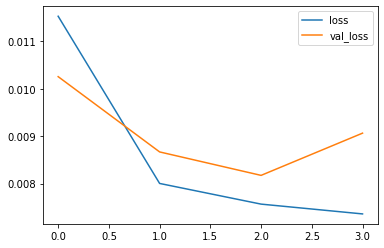

In [41]:
losses = pd.DataFrame(model.history.history)
losses.plot()

## Evaluate on Test Data

In [42]:
first_eval_batch = scaled_train[-length:]

In [43]:
first_eval_batch

array([[0.1038961 , 0.        , 0.72231687, ..., 0.53550296, 0.15909546,
        0.15909546],
       [0.11688312, 0.        , 0.73424191, ..., 0.52662722, 0.40344207,
        0.40344207],
       [0.11688312, 0.        , 0.73424191, ..., 0.51775148, 0.20452271,
        0.20452271],
       ...,
       [0.18181818, 0.        , 0.70017036, ..., 0.50118343, 0.33340004,
        0.33340004],
       [0.09090909, 0.        , 0.70017036, ..., 0.51952663, 0.78747248,
        0.78747248],
       [0.1038961 , 0.        , 0.70017036, ..., 0.53846154, 0.77286372,
        0.77286372]])

In [44]:
first_eval_batch = first_eval_batch.reshape((1, length, scaled_train.shape[1]))

In [45]:
model.predict(first_eval_batch)

array([[0.07943069, 0.01472812, 0.6991676 , 0.40482396, 0.52604085,
        0.44774562, 0.41013163, 0.41249675, 0.6624163 , 0.38787135,
        0.30436653, 0.37568253, 0.66138715, 0.02735109, 0.58808804,
        0.37206942, 0.5055678 , 0.3171032 , 0.5115688 , 0.34572953,
        0.623004  , 0.5041473 , 0.42863724, 0.19119911, 0.59244764,
        0.55076665, 0.5315994 , 0.532977  ]], dtype=float32)

In [46]:
scaled_test[0]

array([0.19480519, 0.        , 0.70017036, 0.3920434 , 0.53007217,
       0.41064526, 0.40616246, 0.41913319, 0.72714286, 0.4115245 ,
       0.30722892, 0.36445121, 0.66777778, 0.        , 0.61119082,
       0.39840637, 0.51618399, 0.32953105, 0.53703704, 0.34024896,
       0.6057377 , 0.52631579, 0.41881579, 0.2       , 0.55283333,
       0.53372781, 0.76305783, 0.76305783])

Now let's put this logic in a for loop to predict into the future for the entire test range.

----

**NOTE: PAY CLOSE ATTENTION HERE TO WHAT IS BEING OUTPUTED AND IN WHAT DIMENSIONS. ADD YOUR OWN PRINT() STATEMENTS TO SEE WHAT IS TRULY GOING ON!!**

In [47]:
n_features = scaled_train.shape[1]
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [48]:
test_predictions

[array([0.07943069, 0.01472812, 0.6991676 , 0.40482396, 0.52604085,
        0.44774562, 0.41013163, 0.41249675, 0.6624163 , 0.38787135,
        0.30436653, 0.37568253, 0.66138715, 0.02735109, 0.58808804,
        0.37206942, 0.5055678 , 0.3171032 , 0.5115688 , 0.34572953,
        0.623004  , 0.5041473 , 0.42863724, 0.19119911, 0.59244764,
        0.55076665, 0.5315994 , 0.532977  ], dtype=float32),
 array([0.06366375, 0.02099216, 0.69794357, 0.40440688, 0.5130432 ,
        0.45386225, 0.40389666, 0.40657592, 0.6408709 , 0.38206652,
        0.31011257, 0.38655764, 0.6623487 , 0.05975695, 0.57806   ,
        0.36447057, 0.49783686, 0.31733102, 0.5019967 , 0.349119  ,
        0.6267354 , 0.49376863, 0.43795407, 0.18934037, 0.58890337,
        0.55365634, 0.5328037 , 0.53149277], dtype=float32),
 array([0.05366983, 0.0263289 , 0.6912705 , 0.40091556, 0.49792457,
        0.46117586, 0.39556202, 0.40533835, 0.61822975, 0.380575  ,
        0.31150678, 0.39152455, 0.6592921 , 0.09446926, 0.5675

In [49]:
scaled_test

array([[0.19480519, 0.        , 0.70017036, ..., 0.53372781, 0.76305783,
        0.76305783],
       [0.37662338, 0.        , 0.70017036, ..., 0.52840237, 0.62337402,
        0.62337402],
       [0.12987013, 0.        , 0.70017036, ..., 0.52366864, 0.08785271,
        0.08785271],
       ...,
       [0.32467532, 0.33333333, 0.87052811, ..., 0.86804734, 0.58415049,
        0.58415049],
       [0.51948052, 0.33333333, 0.87052811, ..., 0.86568047, 0.12627577,
        0.12627577],
       [0.53246753, 0.33333333, 0.87052811, ..., 0.86390533, 0.68260957,
        0.68260957]])

## Inverse Transformations and Compare

In [50]:
true_predictions = scaler.inverse_transform(test_predictions)

In [51]:
true_predictions

array([[81.16163276,  0.44184364, 24.49411387, ...,  7.90795633,
        26.57402214, 26.64285994],
       [69.02108818,  0.62976491, 24.48692875, ...,  7.95679214,
        26.6342016 , 26.5686937 ],
       [61.3257654 ,  0.78986702, 24.44775766, ...,  8.06675203,
        26.5259709 , 26.33139808],
       ...,
       [90.01884222,  1.68560743, 23.34801226, ..., 13.30420786,
        23.23675892, 23.3122178 ],
       [89.99629602,  1.68396123, 23.34969168, ..., 13.30692963,
        23.23683338, 23.31209867],
       [89.97397356,  1.68232363, 23.3513655 , ..., 13.30963327,
        23.23692572, 23.31198697]])

In [52]:
test

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
date,,,,,,,,,,,,,,,,,,,,,
2016-05-25 18:10:00,170,0,24.50,37.86,24.00,34.27,25.00,36.70,24.29,37.79,...,22.00,37.23,16.48,756.1,55.83,2.00,38.17,7.62,38.14,38.14
2016-05-25 18:20:00,310,0,24.50,37.30,23.86,34.33,24.94,36.67,24.29,37.79,...,22.00,37.36,16.47,756.1,55.67,2.00,36.33,7.53,31.16,31.16
2016-05-25 18:30:00,120,0,24.50,36.96,23.73,34.33,24.85,36.50,24.29,37.79,...,22.03,37.39,16.45,756.1,55.50,2.00,34.50,7.45,4.40,4.40
2016-05-25 18:40:00,120,0,24.50,37.00,23.70,34.40,24.84,36.45,24.29,37.90,...,22.10,37.72,16.43,756.1,55.33,2.00,32.67,7.37,27.12,27.12
2016-05-25 18:50:00,120,0,24.49,37.07,23.68,34.52,24.84,36.49,24.28,37.93,...,22.10,37.81,16.42,756.1,55.17,2.00,30.83,7.28,10.27,10.27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-05-27 17:20:00,100,0,25.57,46.56,25.89,42.03,27.20,41.16,24.70,45.59,...,23.20,46.79,22.73,755.2,55.67,3.33,23.67,13.33,43.10,43.10
2016-05-27 17:30:00,90,0,25.50,46.50,25.75,42.08,27.13,41.22,24.70,45.59,...,23.20,46.79,22.60,755.2,56.00,3.50,24.50,13.30,49.28,49.28
2016-05-27 17:40:00,270,10,25.50,46.60,25.63,42.77,27.05,41.69,24.70,45.73,...,23.20,46.79,22.47,755.2,56.33,3.67,25.33,13.27,29.20,29.20


In [53]:
true_predictions = pd.DataFrame(data=true_predictions,columns=test.columns)

In [54]:
true_predictions

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,81.161633,0.441844,24.494114,38.213382,23.949729,35.517685,25.028340,36.574438,23.836914,37.268685,...,21.862471,37.348874,16.901298,755.594558,56.576430,1.911991,40.546858,7.907956,26.574022,26.642860
1,69.021088,0.629765,24.486929,38.201850,23.787649,35.723387,24.983822,36.462416,23.686097,37.140746,...,21.810782,37.422391,16.992343,755.357925,57.284509,1.893404,40.334202,7.956792,26.634202,26.568694
2,61.325765,0.789867,24.447758,38.105315,23.599119,35.969344,24.924313,36.439002,23.527608,37.107873,...,21.757172,37.502795,16.997380,755.100212,58.113334,1.911422,39.681284,8.066752,26.525971,26.331398
3,56.570152,0.933526,24.404203,38.084092,23.417414,36.270232,24.864333,36.462229,23.392266,37.167002,...,21.716360,37.623029,16.995294,754.912926,59.165445,1.946972,38.991778,8.213537,26.420218,26.129960
4,53.624809,1.067099,24.353544,38.122578,23.240289,36.597951,24.802725,36.504902,23.274808,37.271414,...,21.684759,37.757166,16.964238,754.764620,60.294294,1.983201,38.293720,8.370186,26.311481,25.942485
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,90.064503,1.688929,23.344637,44.537693,21.687223,45.228526,24.260876,39.840774,22.317544,42.792010,...,21.164943,44.092702,20.742847,749.327592,66.393099,1.526425,23.676413,13.298719,23.236616,23.312477
284,90.041572,1.687264,23.346328,44.541809,21.689748,45.231509,24.262229,39.844897,22.319179,42.795988,...,21.166092,44.095991,20.745519,749.315553,66.393737,1.526501,23.685713,13.301472,23.236687,23.312344
285,90.018842,1.685607,23.348012,44.545911,21.692264,45.234479,24.263576,39.849003,22.320807,42.799946,...,21.167237,44.099258,20.748188,749.303564,66.394299,1.526586,23.694968,13.304208,23.236759,23.312218
286,89.996296,1.683961,23.349692,44.550000,21.694771,45.237434,24.264918,39.853098,22.322428,42.803891,...,21.168380,44.102506,20.750858,749.291626,66.394779,1.526677,23.704177,13.306930,23.236833,23.312099


# Great Job!

## EXTRA:
### Our Saved Model

In [55]:
from tensorflow.keras.models import load_model

In [56]:
model.save("multivariate.h5")